# Perplexity ratio data

Let's take a look at the text fragment and perplexity ratio score data.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

import numpy as np
import pandas as pd

import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import configuration as config

Working directory: /mnt/arkk/llm_detector/classifier


In [ ]:
# The dataset - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Construct input and output file paths
input_file = f'{config.HANS_DATA_PATH}/{dataset_name}.json'

## 2. Load and prepare data
Load the scored text fragment data from the Hans 2024 corpus:

In [2]:
# Load the data
data_df = pd.read_json(input_file)

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# Enforce dtypes
data_df = data_df.astype({
    'Source record num': np.int64,
    'Fragment length (words)': np.int64,
    'Fragment length (tokens)': np.int64,
    'Dataset': object, #pd.StringDtype(), pandas recommends these, but PyTables for hdf5 can't use them
    'Source': object, #pd.StringDtype(),
    'Generator': object, #pd.StringDtype(),
    'String': object, #pd.StringDtype(),
    'Perplexity': np.float64,
    'Cross-perplexity': np.float64,
    'Perplexity ratio score': np.float64,
    'Reader time (seconds)': np.float64,
    'Writer time (seconds)': np.float64,
    'Reader peak memory (GB)': np.float64,
    'Writer peak memory (GB)': np.float64
})

data_df.head()
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55813 entries, 0 to 55847
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Source record num         55813 non-null  int64  
 1   Fragment length (words)   55813 non-null  int64  
 2   Fragment length (tokens)  55813 non-null  int64  
 3   Dataset                   55813 non-null  object 
 4   Source                    55813 non-null  object 
 5   Generator                 55813 non-null  object 
 6   String                    55813 non-null  object 
 7   Perplexity                55812 non-null  float64
 8   Cross-perplexity          55813 non-null  float64
 9   Perplexity ratio score    55812 non-null  float64
 10  Reader time (seconds)     55813 non-null  float64
 11  Writer time (seconds)     55813 non-null  float64
 12  Reader peak memory (GB)   55813 non-null  float64
 13  Writer peak memory (GB)   55813 non-null  float64
dtypes: float64(

## 3. Human vs synthetic distribution plots
Make some plots with perplexity ratio score and related variables see what we are working with:

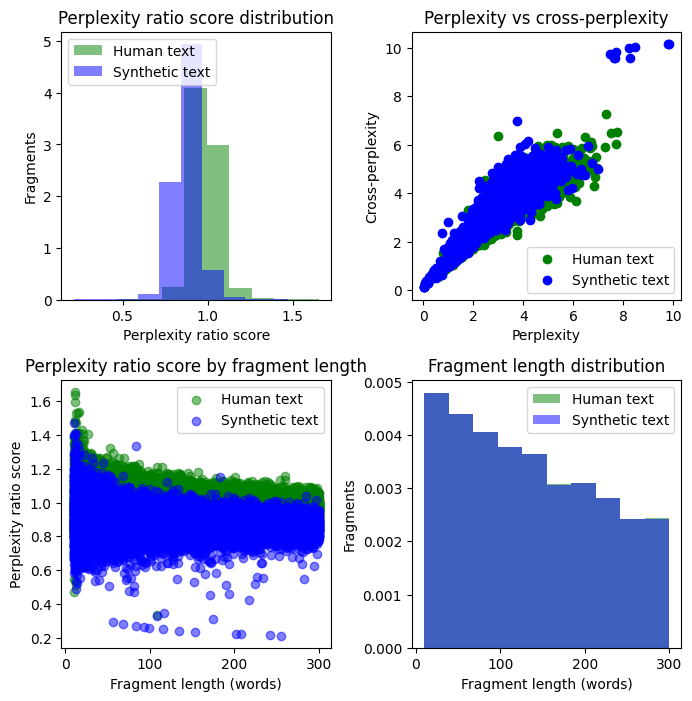

In [3]:
plot_funcs.data_exploration_plot(data_df).show()

Looks OK. Perplexity ratio score distributions clearly look different for human and synthetic text. We have some perplexity and cross-perplexity high outliers, mostly coming from synthetic text. Interestingly, the perplexity ratio score's spread is anti-correlated with text fragment length. Also, the text fragment length distributions are well matched between human and synthetic text fragments - as we expected based on our sampling algorithm.

## 4. Perplexity ratio score by text dataset
Let's take a look at text fragments from the individual original source datasets. Make a boxplot showing the difference in perplexity ratio score distribution for human and synthetic text fragments, split by the original dataset source.

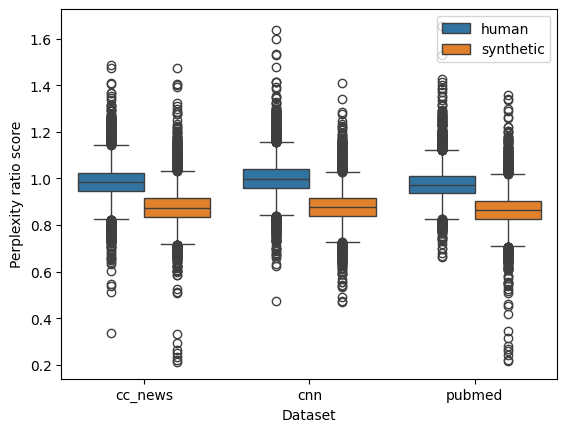

In [4]:
plot_funcs.perplexity_ratio_by_dataset(data_df).show()

OK, all look fairly similar-ish. One source dataset doesn't obviously stand out as much better or worse than the others in terms of separation of human vs synthetic perplexity ratio distribution.

## 5. Perplexity ratio score by text fragment length
Make another boxplot showing the difference in perplexity ratio score distribution for human and synthetic text fragments, this time with the fragments binned by length. This will give us a cleaner picture of how well the perplexity ratio score separates fragments in different length regimes.

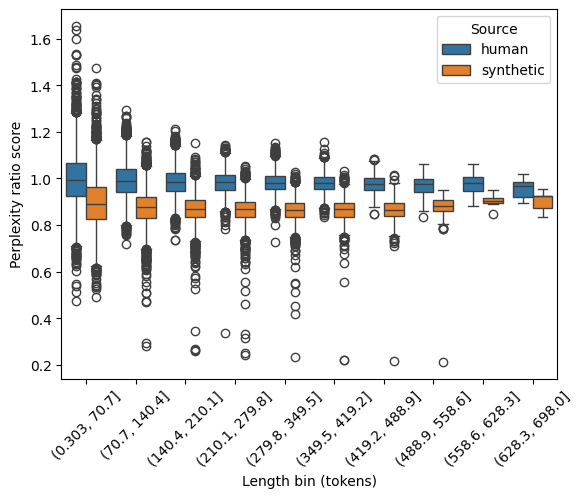

In [5]:
plot_funcs.perplexity_ratio_by_length(data_df).show()

Interesting - the difference in means looks fairly constant across the length bins. But, the perplexity ratio scores from shorter fragments have much larger spread. Let's generate confidence intervals around the difference in means for each length bin.

## 6. Perplexity ratio score: difference in means, human vs synthetic text

In [6]:
helper_funcs.mean_difference_ci(data_df)

Length bin: (70.7, 140.4] tokens
  Human mean: 0.991, synthetic mean: 0.877
  Difference in means = 0.115, 95% CI = (0.112, 0.117)
  p-value (human > synthetic) = 0.0

Length bin: (349.5, 419.2] tokens
  Human mean: 0.981, synthetic mean: 0.865
  Difference in means = 0.116, 95% CI = (0.113, 0.118)
  p-value (human > synthetic) = 0.0

Length bin: (140.4, 210.1] tokens
  Human mean: 0.986, synthetic mean: 0.871
  Difference in means = 0.116, 95% CI = (0.114, 0.118)
  p-value (human > synthetic) = 0.0

Length bin: (0.303, 70.7] tokens
  Human mean: 0.998, synthetic mean: nan
  Difference in means = nan, 95% CI = (nan, nan)
  p-value (human > synthetic) = nan

Length bin: (279.8, 349.5] tokens
  Human mean: 0.981, synthetic mean: 0.864
  Difference in means = 0.117, 95% CI = (0.115, 0.119)
  p-value (human > synthetic) = 0.0

Length bin: (210.1, 279.8] tokens
  Human mean: 0.983, synthetic mean: 0.866
  Difference in means = 0.118, 95% CI = (0.115, 0.120)
  p-value (human > synthetic) = 0

OK, cool - at least in terms of central tendency, the perplexity ratio score does a pretty good job of separating human from synthetic fragments.